In [1]:
import os
import zarr
import timm
import random
import json
import gc
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict

import sys
import torch
from torch.cuda.amp import autocast, GradScaler

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from tqdm import tqdm
from src.kaggle_notebook_metric import compute_lb, extract_particle_results
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

import wandb
from pathlib import Path

notebook_name = os.path.join(Path().resolve()).split("/")[-1]

param = {
    "model": CFG.model_name,
    "resolution": CFG.resolution,
    "augmentation_prob": CFG.augmentation_prob,
    "slice": CFG.slice_,
    "epochs": CFG.epochs,
    "lr": CFG.lr,
    "batch_size": CFG.batch_size,
    "weight_decay": CFG.weight_decay,
    "num_workers": CFG.num_workers,
    "augment_data_ratio": CFG.augment_data_ratio,
}

In [2]:
from sklearn.metrics import *
from scipy.optimize import minimize

# sikii値とexp_namesを入れるとスコアを出力する関数


def compute_score(sikii_list, inferenced_array, exp_name):
    apo_ferritin = sikii_list[0]
    beta_amylase = sikii_list[1]
    beta_galactosidase = sikii_list[2]
    ribosome = sikii_list[3]
    thyroglobulin = sikii_list[4]
    virus_like_particle = sikii_list[5]

    sikii_dict = {
        "apo-ferritin": apo_ferritin,
        "beta-amylase": beta_amylase,
        "beta-galactosidase": beta_galactosidase,
        "ribosome": ribosome,
        "thyroglobulin": thyroglobulin,
        "virus-like-particle": virus_like_particle,
    }

    all_pred = []

    pred_df = inference2pos(
        pred_segmask=inferenced_array, exp_name=exp_name, sikii_dict=sikii_dict
    )

    all_pred.append(pred_df)

    gc.collect()

    pred_df = pd.concat(all_pred, axis=0).reset_index(drop=True)
    pred_df = pred_df[pred_df["particle_type"] != "beta-amylase"]
    pred_df = pred_df.drop_duplicates(
        subset=["experiment", "x", "y", "z"], keep="first"
    ).reset_index(drop=True)
    pred_df = pred_df.reset_index().rename(columns={"index": "id"})

    gt_df = create_gt_df("../../inputs/train/overlay/ExperimentRuns/", [exp_name])

    result_df, lb_score = compute_lb(
        pred_df, "../../inputs/train/overlay/ExperimentRuns/", [exp_name]
    )

    return lb_score


def reduce_computation_sikii_search(
    inferenced_array: np.ndarray, exp_name: str, threshold_candidates: list[float]
) -> tuple[list[float], float]:
    """
    # How
    6つのしきい値が互いに独立してスコアに貢献しているという前提で、
    1次元ずつ最適なしきい値を探す手法を実装する.

    1. 初期の best_thresholds (全要素 0.5 など適当な値) を用意
    2. i=0 から i=5 まで順番に:
       - threshold_candidates をすべて試し、他は固定したまま i 番目だけ変化させてスコアを計算
       - 最良スコアが得られる候補値を確定し、best_thresholds[i] とする
    3. 全部決まったら最終的なスコアを計算して返す

    これにより、全組み合わせ (product) を回すよりも計算量が大幅に減少する.
    """
    # Why not: 6値独立であるという前提が満たされていない場合、近似解になる可能性あり
    best_thresholds = [0.5] * 6  # 適当な初期値でOK

    for i in tqdm(range(6)):
        best_local_score = -float("inf")
        best_local_value = None

        for candidate in threshold_candidates:
            current_thresholds = best_thresholds[:]  # 現在のベストを複製
            current_thresholds[i] = candidate
            score = compute_score(current_thresholds, inferenced_array, exp_name)
            if score > best_local_score:
                best_local_score = score
                best_local_value = candidate

        # i番目のしきい値を最適値に更新
        best_thresholds[i] = best_local_value

    final_score = compute_score(best_thresholds, inferenced_array, exp_name)
    return best_thresholds, final_score

In [ ]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 256, 256),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    if random.random() < p:
        tomogram, segmentation_map = mixup(
            tomogram, segmentation_map, alpha=mixup_alpha
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

In [4]:
from transformers import get_cosine_schedule_with_warmup

In [5]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [6]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor


padf = PadToSize(CFG.resolution)

In [7]:
for vaild_exp_name in ["TS_73_6", "TS_99_9", "TS_6_4", "TS_69_2", "TS_86_3", "TS_6_6"]:
    wandb.init(
        project="czii2024", name=f"{notebook_name}_{vaild_exp_name}", config=param
    )

    vaild_exp_name = [vaild_exp_name]
    train_exp_name = CFG.train_exp_names.copy()
    train_exp_name.remove(vaild_exp_name[0])

    # valid_exp_name[0]の名前でディレクトリを作成
    os.makedirs(f"./{vaild_exp_name[0]}", exist_ok=True)

    train_dataset = EziiDataset(
        exp_names=train_exp_name,
        base_dir="../../inputs/train/",
        particles_name=CFG.particles_name,
        resolution=CFG.resolution,
        zarr_type=CFG.train_zarr_types,
        train=True,
        augmentation=True,
        slice=True,
        pre_read=True,
    )
    valid_dataset = EziiDataset(
        exp_names=vaild_exp_name,
        base_dir="../../inputs/train/",
        particles_name=CFG.particles_name,
        resolution=CFG.resolution,
        zarr_type=CFG.valid_zarr_types,
        augmentation=False,
        train=True,
        slice=True,
        pre_read=True,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        num_workers=CFG.num_workers,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
        num_workers=CFG.num_workers,
    )

    encoder = timm.create_model(
        model_name=CFG.model_name,
        pretrained=True,
        in_chans=3,
        num_classes=0,
        global_pool="",
        features_only=True,
    )
    model = Unet3D(encoder=encoder, num_domains=5).to("cuda")

    optimizer = torch.optim.Adam(
        model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
    )
    criterion = DiceLoss()
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=10,
        num_training_steps=CFG.epochs * len(train_loader),
        # * batch_size,
    )
    scaler = GradScaler()
    seg_loss = SegmentationLoss(criterion)
    padf = PadToSize(CFG.resolution)

    best_model = None
    best_constant = 0
    best_score = -100
    best_particle_score = {}

    grand_train_loss = []
    grand_valid_loss = []
    grand_train_score = []
    grand_valid_score = []

    for epoch in range(CFG.epochs):
        model.train()
        train_loss = []
        valid_loss = []
        with tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]"
        ) as tq:
            for data in tq:
                normalized_tomogram = data["normalized_tomogram"]
                segmentation_map = data["segmentation_map"]
                zarr_embedding_idx = data["zarr_type_embedding_idx"]

                normalized_tomogram = padf(normalized_tomogram)
                segmentation_map = padf(segmentation_map)

                # データ拡張
                normalized_tomogram, segmentation_map = augment_data(
                    normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
                )
                normalized_tomogram = normalized_tomogram.cuda()
                segmentation_map = segmentation_map.long().cuda()
                zarr_embedding_idx = zarr_embedding_idx.cuda()

                optimizer.zero_grad()

                with autocast():
                    pred = model(
                        preprocess_tensor(normalized_tomogram), zarr_embedding_idx
                    )
                    loss = seg_loss(pred, segmentation_map)
                # loss.backward()
                # optimizer.step()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                train_loss.append(loss.item())

                # 確率予測
                prob_pred = torch.softmax(pred, dim=1)
                tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

        del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
        gc.collect()
        torch.cuda.empty_cache()

        with tqdm(
            valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]"
        ) as tq:
            with torch.no_grad():
                for data in tq:
                    normalized_tomogram = data["normalized_tomogram"].cuda()
                    segmentation_map = data["segmentation_map"].long().cuda()
                    zarr_embedding_idx = data["zarr_type_embedding_idx"].cuda()

                    normalized_tomogram = padf(normalized_tomogram)
                    segmentation_map = padf(segmentation_map)

                    with autocast():
                        pred = model(
                            preprocess_tensor(normalized_tomogram), zarr_embedding_idx
                        )
                        loss = seg_loss(pred, segmentation_map)
                    valid_loss.append(loss.item())

                    # 確率予測
                    prob_pred = torch.softmax(pred, dim=1)
                    tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

        del normalized_tomogram, segmentation_map, zarr_embedding_idx, pred, loss
        gc.collect()
        torch.cuda.empty_cache()

        # # ############### validation ################
        train_nshuffle_original_tomogram = defaultdict(list)
        train_nshuffle_pred_tomogram = defaultdict(list)
        train_nshuffle_gt_tomogram = defaultdict(list)

        valid_original_tomogram = defaultdict(list)
        valid_pred_tomogram = defaultdict(list)
        valid_gt_tomogram = defaultdict(list)

        train_mean_scores = []
        valid_mean_scores = []

        # モデルの保存
        make_dir_ = (
            f"../../../../../../../../mnt/d/kaggle-tmp-models/czii2024/{notebook_name}/"
        )
        os.makedirs(make_dir_, exist_ok=True)
        torch.save(model.state_dict(), make_dir_ + f"model_{epoch}.pth")

        # ############### validation ################
        train_nshuffle_original_tomogram = defaultdict(list)
        train_nshuffle_pred_tomogram = defaultdict(list)
        train_nshuffle_gt_tomogram = defaultdict(list)

        valid_original_tomogram = defaultdict(list)
        valid_pred_tomogram = defaultdict(list)
        valid_gt_tomogram = defaultdict(list)

        train_mean_scores = []
        valid_mean_scores = []

        train_inferenced_array = {}
        train_pred_array = []
        train_gt_array = []
        valid_inferenced_array = {}
        valid_gt_array = []

        # for exp_name in tqdm(CFG.train_exp_names):
        for exp_name in vaild_exp_name:  # 5つのデータで試す
            # inferenced_array = inference(model, exp_name, train=False)
            inferenced_array, n_tomogram, segmentation_map = inference(
                model, exp_name, train=False
            )
            valid_inferenced_array[exp_name] = inferenced_array
            base_dir = "../../inputs/train/overlay/ExperimentRuns/"
            gt_df = create_gt_df(base_dir, [exp_name])
            valid_gt_array.append(gt_df)

        valid_gt_array = pd.concat(valid_gt_array)

        b_constant = 0
        b_score = -100
        b_particle_score = {}

        try:
            best_thresholds, final_score = reduce_computation_sikii_search(
                inferenced_array,
                exp_name,
                [
                    0.05,
                    0.1,
                    0.15,
                    0.2,
                    0.25,
                    0.3,
                    0.35,
                    0.4,
                    0.45,
                    0.5,
                    0.55,
                    0.6,
                    0.65,
                    0.7,
                    0.75,
                ],
            )
        except:
            best_thresholds = [0.5] * 6
            final_score = -50

        b_score = final_score
        b_particle_constant = {
            "apo-ferritin": best_thresholds[0],
            "beta-amylase": best_thresholds[1],
            "beta-galactosidase": best_thresholds[2],
            "ribosome": best_thresholds[3],
            "thyroglobulin": best_thresholds[4],
            "virus-like-particle": best_thresholds[5],
        }

        try:
            valid_pred_array = []
            for exp_name in [vaild_exp_name[0]]:
                pred_df = inference2pos(
                    pred_segmask=valid_inferenced_array[exp_name],
                    exp_name=exp_name,
                    sikii_dict=b_particle_constant,
                )
                valid_pred_array.append(pred_df)

            valid_pred_array = pd.concat(valid_pred_array)

            if len(valid_pred_array) != 0:
                result_df, score_ = compute_lb(
                    valid_pred_array,
                    "../../inputs/train/overlay/ExperimentRuns/",
                    vaild_exp_name,
                )
                particle_score = extract_particle_results(result_df)

                b_score = score_
                b_particle_score = particle_score
        except:
            b_score = -50
            b_particle_score = {}

        import gc
        import torch.cuda as cuda

        # del valid_pred_array, valid_gt_array
        gc.collect()
        cuda.empty_cache()

        # print("constant", b_constant, "score", b_score)

        # wandb-log
        train_info = {
            "01_epoch": epoch,
            "02_train_loss": np.mean(train_loss),
            "03_valid_loss": np.mean(valid_loss),
            # "train_score": np.mean(train_mean_scores),
            "04_valid_best_score": b_score,
        }
        train_info = {**train_info, **b_particle_score}
        train_info = {**train_info, **b_particle_constant}
        wandb.log(train_info)

        # score-update
        if b_score > best_score:
            best_score = b_score
            # best_score = np.mean(valid_mean_scores)
            best_model = model.state_dict()
            torch.save(best_model, f"./{vaild_exp_name[0]}/best_model.pth")

        print(
            f"train-epoch-loss:{np.mean(train_loss):.4f}",
            # f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
            # f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
            f"valid-beta4-score:{b_score:.4f}",
        )

        grand_train_loss.append(np.mean(train_loss))
        # grand_valid_loss.append(np.mean(valid_loss))
        # grand_train_score.append(np.mean(train_mean_scores))
        grand_valid_score.append(b_score)

    del model, optimizer, criterion, scheduler, scaler, seg_loss
    gc.collect()
    torch.cuda.empty_cache()

100%|██████████| 6/6 [05:08<00:00, 51.48s/it]


train-epoch-loss:0.9618 valid-beta4-score:0.0725


100%|██████████| 6/6 [04:14<00:00, 42.49s/it]


train-epoch-loss:0.9561 valid-beta4-score:0.0828


100%|██████████| 6/6 [04:19<00:00, 43.30s/it]


train-epoch-loss:0.9530 valid-beta4-score:0.0691


100%|██████████| 6/6 [03:53<00:00, 38.87s/it]


train-epoch-loss:0.9507 valid-beta4-score:0.0986


100%|██████████| 6/6 [04:19<00:00, 43.24s/it]


train-epoch-loss:0.9495 valid-beta4-score:0.1086


100%|██████████| 6/6 [04:30<00:00, 45.13s/it]


train-epoch-loss:0.9489 valid-beta4-score:0.1020


100%|██████████| 6/6 [04:00<00:00, 40.03s/it]


train-epoch-loss:0.9479 valid-beta4-score:0.1208


100%|██████████| 6/6 [03:38<00:00, 36.40s/it]


train-epoch-loss:0.9478 valid-beta4-score:0.1137


100%|██████████| 6/6 [04:01<00:00, 40.19s/it]


train-epoch-loss:0.9475 valid-beta4-score:0.0975


100%|██████████| 6/6 [04:03<00:00, 40.53s/it]


train-epoch-loss:0.9473 valid-beta4-score:0.0907


100%|██████████| 6/6 [04:05<00:00, 40.92s/it]


train-epoch-loss:0.9466 valid-beta4-score:0.1089


100%|██████████| 6/6 [03:59<00:00, 39.90s/it]


train-epoch-loss:0.9472 valid-beta4-score:0.1081


100%|██████████| 6/6 [03:50<00:00, 38.41s/it]


train-epoch-loss:0.9471 valid-beta4-score:0.1175


100%|██████████| 6/6 [03:39<00:00, 36.52s/it]


train-epoch-loss:0.9466 valid-beta4-score:0.0997


100%|██████████| 6/6 [03:53<00:00, 38.86s/it]


train-epoch-loss:0.9470 valid-beta4-score:0.0988


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
03_valid_loss,█▇▆▅▅▃▅▄▅▄▁▅▅▃▅
04_valid_best_score,▁▃▁▅▆▅█▇▅▄▆▆█▅▅
apo-ferritin,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
apoo_ferritin_f4,█▇▃▁▄▂▅▄▅▇▄▆▆▆▆
apoo_ferritin_p,█▅▂▁▂▁▃▃▃▅▃▄▄▄▄
apoo_ferritin_r,▂▂▃▁██▅▃▆▆▅▆▃▃▅
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,█▅▄▂▂▂▂▂▂▂▂▂▁▂▂
beta_amylase_f4,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 6/6 [04:41<00:00, 46.96s/it]


train-epoch-loss:0.9649 valid-beta4-score:0.0876


100%|██████████| 6/6 [04:27<00:00, 44.55s/it]


train-epoch-loss:0.9610 valid-beta4-score:0.1062


100%|██████████| 6/6 [04:25<00:00, 44.23s/it]


train-epoch-loss:0.9569 valid-beta4-score:0.1120


100%|██████████| 6/6 [03:43<00:00, 37.19s/it]


train-epoch-loss:0.9542 valid-beta4-score:0.1080


100%|██████████| 6/6 [03:51<00:00, 38.52s/it]


train-epoch-loss:0.9523 valid-beta4-score:0.1077


100%|██████████| 6/6 [03:42<00:00, 37.08s/it]


train-epoch-loss:0.9515 valid-beta4-score:0.1100


100%|██████████| 6/6 [03:57<00:00, 39.50s/it]


train-epoch-loss:0.9507 valid-beta4-score:0.1174


100%|██████████| 6/6 [03:41<00:00, 36.85s/it]


train-epoch-loss:0.9499 valid-beta4-score:0.1223


100%|██████████| 6/6 [04:41<00:00, 46.99s/it]


train-epoch-loss:0.9495 valid-beta4-score:0.1249


100%|██████████| 6/6 [03:47<00:00, 37.95s/it]


train-epoch-loss:0.9494 valid-beta4-score:0.1205


100%|██████████| 6/6 [03:55<00:00, 39.29s/it]


train-epoch-loss:0.9492 valid-beta4-score:0.1203


100%|██████████| 6/6 [03:50<00:00, 38.44s/it]


train-epoch-loss:0.9486 valid-beta4-score:0.1173


100%|██████████| 6/6 [03:42<00:00, 37.07s/it]


train-epoch-loss:0.9486 valid-beta4-score:0.1218


100%|██████████| 6/6 [04:14<00:00, 42.37s/it]


train-epoch-loss:0.9485 valid-beta4-score:0.1167


100%|██████████| 6/6 [03:42<00:00, 37.11s/it]


train-epoch-loss:0.9489 valid-beta4-score:0.1229


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▅▃▃▂▂▂▁▁▁▁▁▁▁
03_valid_loss,█▅▃▅▅▃▁▅▁▃▃▁▃▄▄
04_valid_best_score,▁▄▆▅▅▅▇██▇▇▇▇▆█
apo-ferritin,█▄▃▃▃▁▃▁▃▁▁▁▁▃▁
apoo_ferritin_f4,▅▆▅██▁▂▁▁▁▁▁▁▂▁
apoo_ferritin_p,▄▆▄██▁▂▁▁▁▁▁▁▂▁
apoo_ferritin_r,▃██▃▂▁▁▁▂▁▁▁▁▁▁
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
beta_amylase_f4,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 6/6 [07:00<00:00, 70.09s/it]


train-epoch-loss:0.9627 valid-beta4-score:0.0818


100%|██████████| 6/6 [04:48<00:00, 48.12s/it]


train-epoch-loss:0.9580 valid-beta4-score:0.1147


100%|██████████| 6/6 [04:34<00:00, 45.75s/it]


train-epoch-loss:0.9548 valid-beta4-score:0.1347


100%|██████████| 6/6 [04:03<00:00, 40.51s/it]


train-epoch-loss:0.9530 valid-beta4-score:0.1418


100%|██████████| 6/6 [04:05<00:00, 40.98s/it]


train-epoch-loss:0.9516 valid-beta4-score:0.1434


100%|██████████| 6/6 [04:00<00:00, 40.09s/it]


train-epoch-loss:0.9506 valid-beta4-score:0.1688


100%|██████████| 6/6 [03:59<00:00, 39.94s/it]


train-epoch-loss:0.9498 valid-beta4-score:0.1778


100%|██████████| 6/6 [03:54<00:00, 39.10s/it]


train-epoch-loss:0.9493 valid-beta4-score:0.1822


100%|██████████| 6/6 [03:55<00:00, 39.27s/it]


train-epoch-loss:0.9492 valid-beta4-score:0.1993


100%|██████████| 6/6 [04:00<00:00, 40.03s/it]


train-epoch-loss:0.9486 valid-beta4-score:0.2065


100%|██████████| 6/6 [03:54<00:00, 39.12s/it]


train-epoch-loss:0.9485 valid-beta4-score:0.2186


100%|██████████| 6/6 [03:55<00:00, 39.19s/it]


train-epoch-loss:0.9484 valid-beta4-score:0.2031


100%|██████████| 6/6 [03:52<00:00, 38.71s/it]


train-epoch-loss:0.9484 valid-beta4-score:0.2109


100%|██████████| 6/6 [03:50<00:00, 38.41s/it]


train-epoch-loss:0.9483 valid-beta4-score:0.1907


100%|██████████| 6/6 [03:52<00:00, 38.82s/it]


train-epoch-loss:0.9482 valid-beta4-score:0.2006


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁
03_valid_loss,█▇▄▃▆▄▆▅▆▁▃▁▅▅▆
04_valid_best_score,▁▃▄▄▄▅▆▆▇▇█▇█▇▇
apo-ferritin,▁▁▃▆▆▆▆▆▆▆▄▆▆█▆
apoo_ferritin_f4,▂▃▄▁▃▇█▂▅▇▄▆▆▆▇
apoo_ferritin_p,▁▃▃▁▃▆▇▂▅▆▃▅█▆▆
apoo_ferritin_r,█▅▄▂▂▆▆▁▃██▇▂▂▅
beta-amylase,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,█▅▃▃▂▂▂▂▂▁▂▁▁▁▁
beta_amylase_f4,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 6/6 [04:36<00:00, 46.09s/it]


train-epoch-loss:0.9527 valid-beta4-score:0.1309


100%|██████████| 6/6 [04:37<00:00, 46.22s/it]


train-epoch-loss:0.9492 valid-beta4-score:0.1351


100%|██████████| 6/6 [07:26<00:00, 74.34s/it]


train-epoch-loss:0.9436 valid-beta4-score:0.1194


100%|██████████| 6/6 [04:55<00:00, 49.18s/it]


train-epoch-loss:0.9385 valid-beta4-score:0.1310


100%|██████████| 6/6 [04:20<00:00, 43.40s/it]


train-epoch-loss:0.9345 valid-beta4-score:0.1483


100%|██████████| 6/6 [04:02<00:00, 40.48s/it]


train-epoch-loss:0.9319 valid-beta4-score:0.1437


100%|██████████| 6/6 [05:19<00:00, 53.27s/it]


train-epoch-loss:0.9313 valid-beta4-score:0.1679


100%|██████████| 6/6 [04:37<00:00, 46.19s/it]


train-epoch-loss:0.9297 valid-beta4-score:0.1327


100%|██████████| 6/6 [08:27<00:00, 84.65s/it]


train-epoch-loss:0.9289 valid-beta4-score:0.1517


100%|██████████| 6/6 [05:08<00:00, 51.47s/it]


train-epoch-loss:0.9290 valid-beta4-score:0.1479


100%|██████████| 6/6 [07:18<00:00, 73.08s/it]


train-epoch-loss:0.9285 valid-beta4-score:0.1513


100%|██████████| 6/6 [04:48<00:00, 48.02s/it]


train-epoch-loss:0.9284 valid-beta4-score:0.1396


100%|██████████| 6/6 [08:15<00:00, 82.61s/it]


train-epoch-loss:0.9284 valid-beta4-score:0.1604


100%|██████████| 6/6 [06:36<00:00, 66.04s/it]


train-epoch-loss:0.9284 valid-beta4-score:0.1575


100%|██████████| 6/6 [08:06<00:00, 81.15s/it]


train-epoch-loss:0.9281 valid-beta4-score:0.1260


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁
03_valid_loss,█▆▅▆▂▅▄▁▄▄▂▁▃▄▂
04_valid_best_score,▃▃▁▃▅▅█▃▆▅▆▄▇▆▂
apo-ferritin,█▁▂▂▂▂▂▂▂▂▂▂▂▂▂
apoo_ferritin_f4,█▅▁▂▁▂▁▁▁▁▁▂▁▁▁
apoo_ferritin_p,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
apoo_ferritin_r,▁▂▆▇▃▂▄▃▆▅▇▆▃▆█
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,▁▄███▁▁▁▁▁▁▁▁▁▁
beta_amylase_f4,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 6/6 [06:06<00:00, 61.09s/it]


train-epoch-loss:0.9636 valid-beta4-score:0.0739


100%|██████████| 6/6 [04:31<00:00, 45.25s/it]


train-epoch-loss:0.9588 valid-beta4-score:0.0486


100%|██████████| 6/6 [04:24<00:00, 44.00s/it]


train-epoch-loss:0.9552 valid-beta4-score:0.0880


100%|██████████| 6/6 [04:11<00:00, 41.84s/it]


train-epoch-loss:0.9530 valid-beta4-score:0.1213


100%|██████████| 6/6 [04:00<00:00, 40.03s/it]


train-epoch-loss:0.9517 valid-beta4-score:0.1295


100%|██████████| 6/6 [03:57<00:00, 39.53s/it]


train-epoch-loss:0.9508 valid-beta4-score:0.1331


100%|██████████| 6/6 [03:54<00:00, 39.17s/it]


train-epoch-loss:0.9497 valid-beta4-score:0.1437


100%|██████████| 6/6 [04:05<00:00, 40.85s/it]


train-epoch-loss:0.9491 valid-beta4-score:0.1469


100%|██████████| 6/6 [04:04<00:00, 40.72s/it]


train-epoch-loss:0.9482 valid-beta4-score:0.1581


100%|██████████| 6/6 [04:00<00:00, 40.10s/it]


train-epoch-loss:0.9480 valid-beta4-score:0.1524


100%|██████████| 6/6 [03:52<00:00, 38.73s/it]


train-epoch-loss:0.9481 valid-beta4-score:0.1526


100%|██████████| 6/6 [03:59<00:00, 39.91s/it]


train-epoch-loss:0.9478 valid-beta4-score:0.1572


100%|██████████| 6/6 [03:52<00:00, 38.82s/it]


train-epoch-loss:0.9474 valid-beta4-score:0.1643


100%|██████████| 6/6 [04:05<00:00, 40.99s/it]


train-epoch-loss:0.9474 valid-beta4-score:0.1541


100%|██████████| 6/6 [03:57<00:00, 39.50s/it]


train-epoch-loss:0.9478 valid-beta4-score:0.1535


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


01_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
02_train_loss,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁
03_valid_loss,█▇▄▅▃▁▄▅▄▄▁▄▃▃▁
04_valid_best_score,▃▁▃▅▆▆▇▇█▇▇██▇▇
apo-ferritin,█▅▁▂▅▅▂▂▂▂▂▂▂▂▂
apoo_ferritin_f4,▄▂▁▂▁▅▇▅▅▃▅█▄▇▆
apoo_ferritin_p,▂▁▂▂▁█▃▂▂▂▂▃▂▃▃
apoo_ferritin_r,▆▂▁▁▁▁█▇▆▃▄▆▄▅▇
beta-amylase,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta-galactosidase,█▇▄▂▂▁▂▂▂▂▁▁▂▁▂
beta_amylase_f4,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 6/6 [05:26<00:00, 54.46s/it]


train-epoch-loss:0.9536 valid-beta4-score:0.0386


100%|██████████| 6/6 [04:25<00:00, 44.31s/it]


train-epoch-loss:0.9491 valid-beta4-score:0.0512


100%|██████████| 6/6 [03:58<00:00, 39.69s/it]


train-epoch-loss:0.9456 valid-beta4-score:0.0673


100%|██████████| 6/6 [03:35<00:00, 35.92s/it]


train-epoch-loss:0.9423 valid-beta4-score:0.1040


100%|██████████| 6/6 [03:46<00:00, 37.67s/it]


train-epoch-loss:0.9396 valid-beta4-score:0.0822


100%|██████████| 6/6 [03:40<00:00, 36.76s/it]


train-epoch-loss:0.9377 valid-beta4-score:0.0603


100%|██████████| 6/6 [03:58<00:00, 39.71s/it]


train-epoch-loss:0.9362 valid-beta4-score:0.0779


100%|██████████| 6/6 [03:42<00:00, 37.10s/it]


train-epoch-loss:0.9356 valid-beta4-score:0.1368


100%|██████████| 6/6 [03:43<00:00, 37.25s/it]


train-epoch-loss:0.9354 valid-beta4-score:0.0856


100%|██████████| 6/6 [03:35<00:00, 35.90s/it]


train-epoch-loss:0.9351 valid-beta4-score:0.1109


100%|██████████| 6/6 [03:40<00:00, 36.77s/it]


train-epoch-loss:0.9351 valid-beta4-score:0.1369


100%|██████████| 6/6 [03:40<00:00, 36.68s/it]


train-epoch-loss:0.9344 valid-beta4-score:0.1266


100%|██████████| 6/6 [03:41<00:00, 36.97s/it]


train-epoch-loss:0.9346 valid-beta4-score:0.1281


100%|██████████| 6/6 [03:41<00:00, 36.98s/it]


train-epoch-loss:0.9349 valid-beta4-score:0.1516


100%|██████████| 6/6 [03:37<00:00, 36.22s/it]


train-epoch-loss:0.9346 valid-beta4-score:0.1637


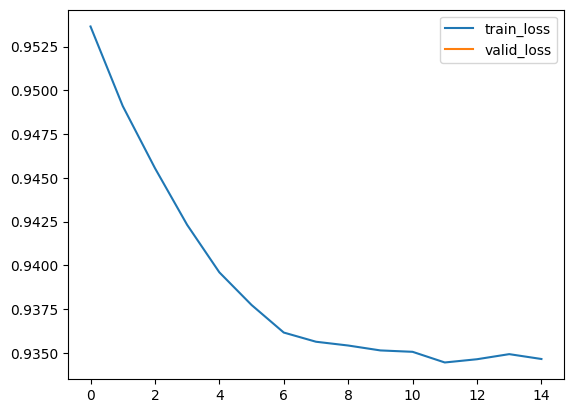

In [8]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

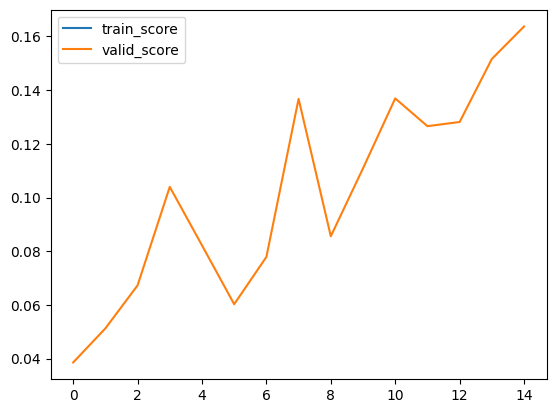

In [9]:
# train_scoreとvalid_scoreのプロット
plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [10]:
random.random()

0.9176294086859996